In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

blinks = pd.read_csv("sample-data/blinks.csv")
fixations = pd.read_csv("sample-data/fixations.csv")
saccades = pd.read_csv("sample-data/saccades.csv")
gaze_positions = pd.read_csv("sample-data/gaze_positions.csv")

# test to see its working
print(blinks.head())

   blink id  start timestamp [ns]   end timestamp [ns]  duration [ms]
0         1   1747308624362212864  1747308624622460928     260.248064
1         2   1747308627605311744  1747308627795434752     190.123008
2         3   1747308650396380928  1747308650681753856     285.372928
3         4   1747308654325099776  1747308654705485824     380.386048
4         5   1747308663894022912  1747308664114145792     220.122880


In [24]:
#  reusable function to find best number of components for GMM
def select_best_gmm(X_scaled, max_components=6):
    bic_scores = []
    aic_scores = []
    n_range = range(1, max_components + 1)

    for n in n_range:
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(X_scaled)
        bic_scores.append(gmm.bic(X_scaled))
        aic_scores.append(gmm.aic(X_scaled))

    plt.plot(n_range, bic_scores, label='BIC', marker='o')
    plt.plot(n_range, aic_scores, label='AIC', marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Score')
    plt.title('Model Selection: BIC & AIC')
    plt.legend()
    plt.show()

    best_n = n_range[bic_scores.index(min(bic_scores))]
    print(f"Optimal number of components (lowest BIC): {best_n}")
    return best_n

##### Blinks

In [25]:
# inter-blink interval: time duration between two consecutive blinks; the length of time the eyelids are open between blinks
# sorting by timestamp (but maybe redundant)
blinks = blinks.sort_values(by='start timestamp [ns]')
blinks['IBI [ms]'] = blinks['start timestamp [ns]'].diff() / 1e6  # convert ns → ms just to keep consistent

# strip unnecessary values and make a standalone dataframe we can safely modify 
blink_features = blinks[['duration [ms]', 'IBI [ms]']].dropna().copy()
blink_features['event_type'] = 'blink'

# scale
scaler = StandardScaler()
blink_scaled = scaler.fit_transform(blink_features[['duration [ms]', 'IBI [ms]']])

In [27]:
# Gaussian Mixture Model (GMM) clustering
# components 2 because so little data, random state is just my Blandford number lol
gmm = GaussianMixture(n_components=2, random_state=35)
blink_features['cluster'] = gmm.fit_predict(blink_scaled)

# check it works
print(blink_features['cluster'].value_counts())

cluster
1    10
0     4
Name: count, dtype: int64


##### Fixations

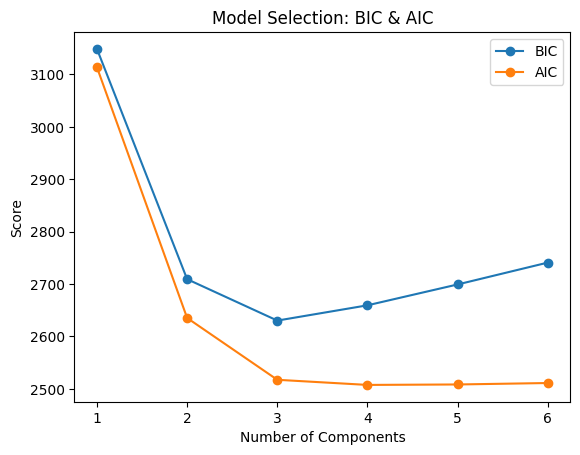

Optimal number of components (lowest BIC): 3


In [29]:
# including x and y here to later calculate spatial drift which could indicate fatigue/time
fixation_features = fixations[['duration [ms]', 'fixation x [px]', 'fixation y [px]']].dropna().copy()
fixation_features['event_type'] = 'fixation'

# scale
fixation_scaled = scaler.fit_transform(fixation_features[['duration [ms]', 'fixation x [px]', 'fixation y [px]']])

# Run BIC (Bayesian Information Criterion) test to see number of components for cluster 
best_n = select_best_gmm(fixation_scaled, max_components=6)

In [30]:
# clustering, components chosen based on BIC
gmm = GaussianMixture(n_components=3, random_state=35)
fixation_features['cluster'] = gmm.fit_predict(fixation_scaled)

# check it works
print(fixation_features['cluster'].value_counts())

cluster
2    170
0    135
1     59
Name: count, dtype: int64


calculating spatial drift to (hopefully) indicate fatigue from fixation coordinates

In [31]:
# Add timestamp ONLY for temporal drift calculation
fixation_temp = fixations[
    ['start timestamp [ns]', 'fixation x [px]', 'fixation y [px]']
].dropna().copy()

# Sort just in case the CSV is out of order
fixation_temp = fixation_temp.sort_values(by='start timestamp [ns]')

# Compute rolling dispersion over a window of 10 fixations
fixation_temp['x_dispersion'] = fixation_temp['fixation x [px]'].rolling(window=10).std()
fixation_temp['y_dispersion'] = fixation_temp['fixation y [px]'].rolling(window=10).std()

# Combine for total spatial drift (Euclidean std)
fixation_temp['spatial_drift'] = (
    fixation_temp['x_dispersion']**2 + fixation_temp['y_dispersion']**2
)**0.5

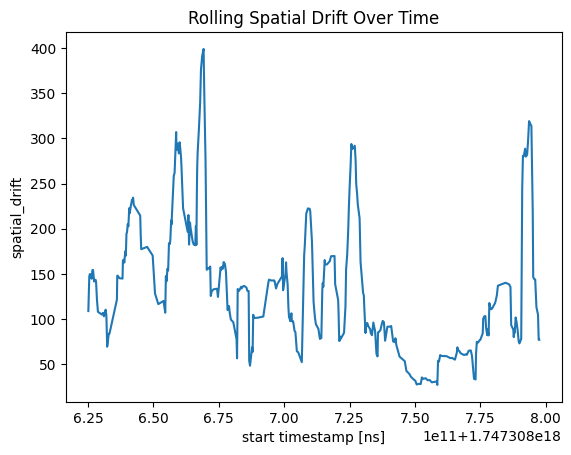

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=fixation_temp, x='start timestamp [ns]', y='spatial_drift')
plt.title("Rolling Spatial Drift Over Time")
plt.show()

##### Saccades

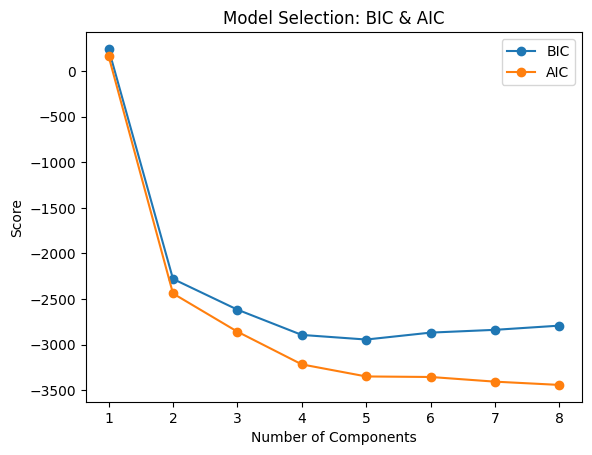

Optimal number of components (lowest BIC): 5


In [35]:
saccades_features = saccades[['duration [ms]', 'amplitude [px]', 'amplitude [deg]', 'mean velocity [px/s]', 'peak velocity [px/s]']].dropna().copy()
saccades_features['event_type'] = 'fixation'

# scale
saccades_scaled = scaler.fit_transform(saccades_features[['duration [ms]', 'amplitude [px]', 'amplitude [deg]', 'mean velocity [px/s]', 'peak velocity [px/s]']])

# BIC test
best_n = select_best_gmm(saccades_scaled, max_components=8)

In [36]:
# clustering, components chosen based on BIC
gmm = GaussianMixture(n_components=5, random_state=35)
fixation_features['cluster'] = gmm.fit_predict(fixation_scaled)

##### Gaze Positions

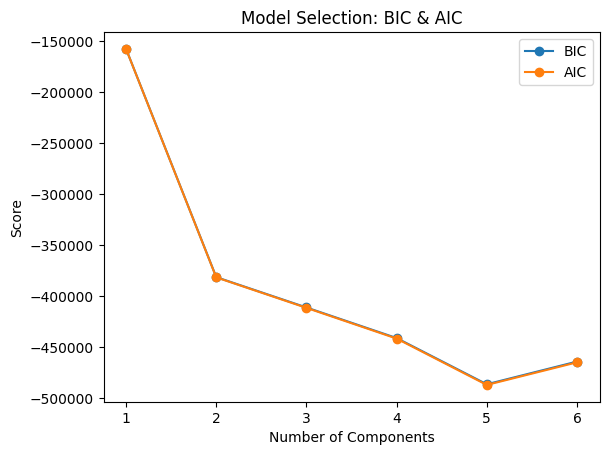

Optimal number of components (lowest BIC): 5


In [ ]:
# using all features of gaze positions csv
gaze_features = gaze_positions[[
    'gaze x [px]', 
    'gaze y [px]', 
    'azimuth [deg]', 
    'elevation [deg]'
]].dropna().copy()
gaze_features['event_type'] = 'gaze-position'

# scale
scaler = StandardScaler()
gaze_scaled = scaler.fit_transform(gaze_features.drop(columns='event_type'))

# BIC test
best_n = select_best_gmm(gaze_scaled, max_components=6)

In [53]:
# clustering
gmm = GaussianMixture(n_components=5, random_state=35)
gaze_features['cluster'] = gmm.fit_predict(gaze_scaled)

# check it works
print(gaze_features['cluster'].value_counts())

cluster
2    16518
4     9733
3     5190
0     2692
1     1306
Name: count, dtype: int64


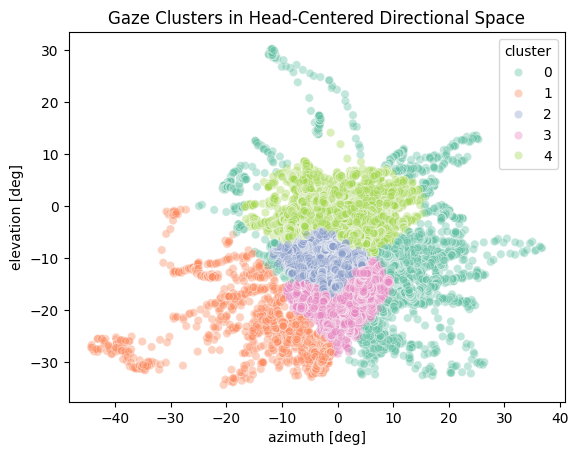

In [54]:
# difference between clusters for gaze positions
gaze_features.groupby('cluster')[['gaze x [px]', 'gaze y [px]', 'azimuth [deg]', 'elevation [deg]']].mean()

sns.scatterplot(
    data=gaze_features,
    x='azimuth [deg]',
    y='elevation [deg]',
    hue='cluster',
    palette='Set2',
    alpha=0.4
)
plt.title("Gaze Clusters in Head-Centered Directional Space")
plt.show()